In [12]:
import urllib.request
from pathlib import Path
import os
import pandas as pd
import numpy as np
path = Path()

# Dictionary of file names and download links
files = {'PEP.csv':'https://query1.finance.yahoo.com/v7/finance/download/PEP?period1=1501718400&period2=1627948800&interval=1d&events=history&includeAdjustedClose=true',
         'KO.csv':'https://query1.finance.yahoo.com/v7/finance/download/KO?period1=1501718400&period2=1627948800&interval=1d&events=history&includeAdjustedClose=true'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
      urllib.request.urlretrieve(url,filename)

In [13]:
# Read in file
pep_df = pd.read_csv('PEP.csv')
ko_df = pd.read_csv('KO.csv')

# Display the first n rows (default is 5 rows)
ko_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-03,45.650002,45.950001,45.630001,45.669998,40.073311,14261400
1,2017-08-04,45.669998,45.759998,45.470001,45.500000,39.924152,9523600
2,2017-08-07,45.520000,45.759998,45.500000,45.639999,40.046989,6226300
3,2017-08-08,45.639999,45.820000,45.549999,45.599998,40.011887,5747900
4,2017-08-09,45.560001,45.660000,45.330002,45.590000,40.003120,9635300
...,...,...,...,...,...,...,...
1001,2021-07-27,57.110001,57.540001,56.919998,57.259998,57.259998,12794400
1002,2021-07-28,56.990002,57.160000,56.630001,56.740002,56.740002,9858000
1003,2021-07-29,57.070000,57.250000,56.860001,57.049999,57.049999,9599100
1004,2021-07-30,57.150002,57.250000,56.900002,57.029999,57.029999,11727000


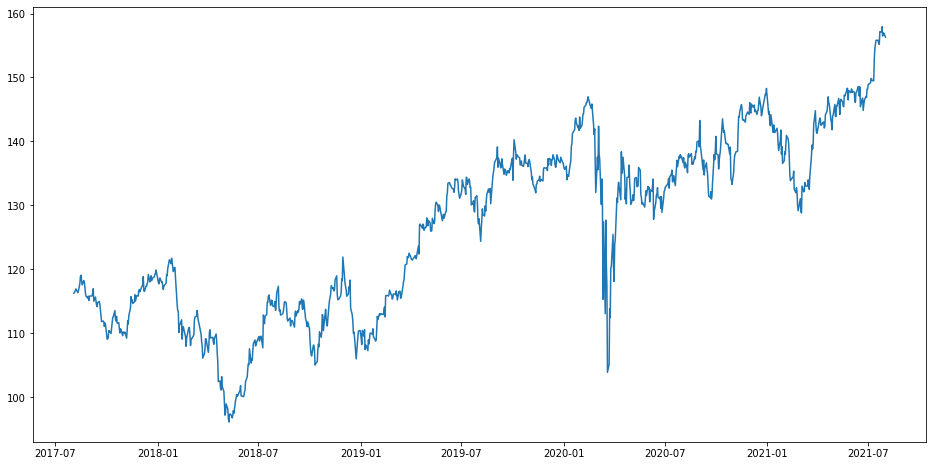

In [17]:
import matplotlib.pyplot as plt
#setting index as date
pep_df['Date'] = pd.to_datetime(pep_df.Date,format='%Y-%m-%d')
pep_df.index = pep_df['Date']
ko_df['Date'] = pd.to_datetime(ko_df.Date,format='%Y-%m-%d')
ko_df.index = ko_df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(pep_df['Close'], label='Close Price history')

In [23]:
pep_df = pep_df.loc[:,['Date','Close']]
pep_df_rename = pep_df.rename(columns={'Close':'PEP_Close','Date':'date'})
ko_df = ko_df.loc[:,['Date','Close']]
ko_df_rename = ko_df.rename(columns={'Close':'KO_Close','Date':'date'})
data = pep_df_rename.merge(ko_df_rename,how='left',on=['date'])
data.index = data['date']
data.head()

,date,PEP_Close,KO_Close
date,,,
2017-08-03,2017-08-03,116.300003,45.669998
2017-08-04,2017-08-04,116.370003,45.500000
2017-08-07,2017-08-07,116.959999,45.639999
2017-08-08,2017-08-08,116.709999,45.599998
2017-08-09,2017-08-09,116.629997,45.590000


In [31]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = data.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(pep_df)),columns=['Date', 'PEP_Close', 'KO_Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['date'][i]
    new_data['PEP_Close'][i] = data['PEP_Close'][i]
    new_data['KO_Close'][i] = data['KO_Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

bound = dataset.shape[0]*0.8
bound = round(bound)

train = dataset[0:bound,:]
valid = dataset[bound:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)



In [33]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,:])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)


In [34]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

745/745 - 32s - loss: 0.0056


In [35]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,2)
inputs = scaler.transform(inputs)
inputs.shape


(261, 2)

In [36]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,:])
X_test = np.array(X_test)

In [37]:
closing_price = model.predict(X_test)
b = np.append(closing_price,np.zeros([len(closing_price),1]),1)
closing_price = scaler.inverse_transform(b)
closing_price = closing_price[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


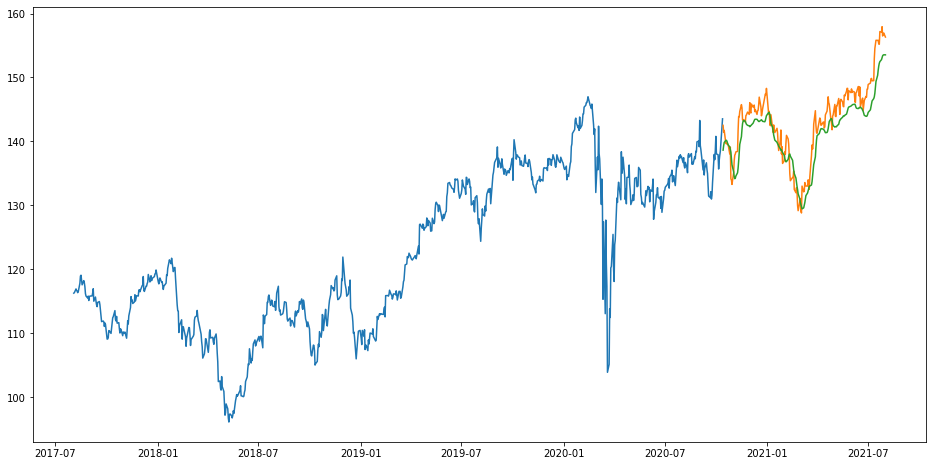

In [39]:
#for plotting
train = new_data[:bound]
valid = new_data[bound:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['PEP_Close'])
plt.plot(valid[['PEP_Close','Predictions']])